In [130]:
%pylab inline
import os
import glob
import pandas as pd
import re
from collections import OrderedDict
import seaborn as sns
sns.set_context('paper', font_scale=2)
sns.set_style('white')
def clean_tx(tx):
    return re.sub(r'\.[0-9]+', '', tx)

root_dir = '/staging/as/skchoudh/re-ribo-analysis/hg38/SRP010679/ribocop_results_Feb2019_longest/'

def get_uorf(df):
    return df.loc[df.ORF_type=='uORF',]
def get_translating(df):
    return df.loc[df.status=='translating']
def get_tx_from_orfid(orfid):
    splitted = orfid.split('_')
    if len(splitted) == 4:
        txid = splitted[0]
    elif len(splitted)==5:
        txid = splitted[0] + '_' + splitted[1]
    else:
        raise RuntimeError('Found:{}'.format(splitted))
    return txid

Populating the interactive namespace from numpy and matplotlib


In [122]:
annotation = pd.read_table('/staging/as/skchoudh/ribocop_hg38_feb2019_annotation_candidate_orfs.tsv').set_index('ORF_ID')
annotation

KeyboardInterrupt: 

In [8]:
orf_df = OrderedDict()
for f in glob.glob('{}/*_translating_ORFs.tsv'.format(root_dir)):
    filename = os.path.basename(f).replace('_translating_ORFs.tsv', '')
    orf_df[filename] = pd.read_table(f)


In [13]:
orf_df_annotated = OrderedDict()
for key, df in orf_df.items():
    df = df[df.ORF_type=='annotated'].sort_values(by=['transcript_id', 'ORF_ID', 'gene_id'])
    orf_df_annotated[key] = df
    print(df.shape)

(94421, 16)
(94421, 16)
(94421, 16)
(94421, 16)
(94421, 16)
(94421, 16)
(94421, 16)
(94421, 16)
(94421, 16)
(94421, 16)
(94421, 16)
(94421, 16)


In [14]:
def eval_profile(profile):
    profile = eval(profile)
    return sum(profile)



In [17]:
orf_profiles_sum = OrderedDict()
for key, df in orf_df_annotated.items():
    df['profile_sum'] = df.profile.apply(eval_profile)
    orf_profiles_sum[key] = df[['transcript_id', 'profile_sum']]


In [20]:
for key,df in orf_profiles_sum.items():
    df.to_csv('/staging/as/skchoudh/SRP010679_tx_counts/{}.tsv'.format(key), sep='\t', header=None, index=False)
    

In [4]:
def get_start_end_coordinates(orf_id):
    #orf_id = row['ORF_ID']
    splitted = orf_id.split('_')
    stop = splitted[-2]
    start = splitted[-3]
    return pd.Series([int(start), int(stop)])


# Approach

We need the transcript level counts to process in riborex. We take the simple approach of first groupring 
everythong at the gene level. We only care about the protein_coding genes and the annotated ones.

In [5]:
selected_df = orf_df[filename]

selected_df[['start', 'stop']] =selected_df['ORF_ID'].apply(get_start_end_coordinates)
selected_df_grouped = selected_df.groupby(['gene_id', 'transcript_id'])

    
    


In [ ]:
for key, group_df in selected_df_grouped:
    profile_series_sum = pd.Series([])
    index_series_sum = pd.Series([])
    for index, row in group_df.iterrows():
        profile = eval(row['profile'])
        profile_series = pd.Series(profile, index=range(int(row['start']), int(row['stop'])+1 ))
        index_series = pd.Series([1]*(row['stop']-row['start']+1),  index=range(int(row['start']), int(row['stop'])+1 ))
        profile_series_sum = profile_series_sum.add(profile_series)
        index_series_sum = index_series_sum.add(index_series)
    break
    

In [ ]:
orf_id_range_index = {}
for orf_id, row in annotation.iterrows():
    intervals_string = row['coordinate']
    intervals = intervals_string.split(',')
    interval_range_index = []
    for interval in intervals:
        start, end = interval.split('-')
        interval_range_index = interval_range_index + list(range(int(start), int(end)+1))
    orf_id_range_index[orf_id] = interval_range_index

In [21]:
metadata = pd.read_table('/staging/as/skchoudh/SRP010679_tx_counts/metadata_ribo.tsv')
metadata

,study_accession,experiment_accession,sample_accession,run_accession,cell_line,sample_type,source_name,treatment
0,SRP010679,SRX118286,SRS290855,SRR403883,pc3,ribosome protected rna,pc3 human prostate cancer cells,vehicle
1,SRP010679,SRX118288,SRS290857,SRR403885,pc3,ribosome protected rna,pc3 human prostate cancer cells,rapamycin
2,SRP010679,SRX118290,SRS290859,SRR403887,pc3,ribosome protected rna,pc3 human prostate cancer cells,pp242
3,SRP010679,SRX118292,SRS290861,SRR403889,pc3,ribosome protected rna,pc3 human prostate cancer cells,vehicle
4,SRP010679,SRX118294,SRS290863,SRR403891,pc3,ribosome protected rna,pc3 human prostate cancer cells,rapamycin
5,SRP010679,SRX118296,SRS290865,SRR403893,pc3,ribosome protected rna,pc3 human prostate cancer cells,pp242


In [23]:
metadata = metadata.loc[metadata.treatment.isin(['vehicle', 'pp242']),]

In [24]:
metadata

,study_accession,experiment_accession,sample_accession,run_accession,cell_line,sample_type,source_name,treatment
0,SRP010679,SRX118286,SRS290855,SRR403883,pc3,ribosome protected rna,pc3 human prostate cancer cells,vehicle
2,SRP010679,SRX118290,SRS290859,SRR403887,pc3,ribosome protected rna,pc3 human prostate cancer cells,pp242
3,SRP010679,SRX118292,SRS290861,SRR403889,pc3,ribosome protected rna,pc3 human prostate cancer cells,vehicle
5,SRP010679,SRX118296,SRS290865,SRR403893,pc3,ribosome protected rna,pc3 human prostate cancer cells,pp242


In [71]:
vehicle1 = orf_df['SRX118286']
vehicle2 = orf_df['SRX118292']

treatment1 = orf_df['SRX118290']
treatment2 = orf_df['SRX118296']




vehicle1 = get_uorf(vehicle1)
vehicle2 = get_uorf(vehicle2)

treatment1 = get_uorf(treatment1)
treatment2 = get_uorf(treatment2)
vehicle1['vehicle1_profile_sum'] = vehicle1.profile.apply(eval_profile)
vehicle2['vehicle2_profile_sum'] = vehicle2.profile.apply(eval_profile)

treatment1['treatment1_profile_sum'] = treatment1.profile.apply(eval_profile)
treatment2['treatment2_profile_sum'] = treatment2.profile.apply(eval_profile)
vehicle1_sum_df = vehicle1[['ORF_ID', 'vehicle1_profile_sum']]
vehicle2_sum_df = vehicle2[['ORF_ID', 'vehicle2_profile_sum']]

treatment1_sum_df = treatment1[['ORF_ID', 'treatment1_profile_sum']]
treatment2_sum_df = treatment2[['ORF_ID', 'treatment2_profile_sum']]
vehicle1_sum_df.to_csv('/staging/as/skchoudh/SRP010679_uORF_differential_analysis/SRX118286.tsv', header=False, index=False, sep='\t')
vehicle2_sum_df.to_csv('/staging/as/skchoudh/SRP010679_uORF_differential_analysis/SRX118292.tsv', header=False, index=False, sep='\t')

treatment1_sum_df.to_csv('/staging/as/skchoudh/SRP010679_uORF_differential_analysis/SRX118290.tsv', header=False, index=False, sep='\t')
treatment2_sum_df.to_csv('/staging/as/skchoudh/SRP010679_uORF_differential_analysis/SRX118296.tsv', header=False, index=False, sep='\t')



In [79]:
vehicle1 = orf_df['SRX118286']
vehicle2 = orf_df['SRX118292']

treatment1 = orf_df['SRX118290']
treatment2 = orf_df['SRX118296']




vehicle1 = get_uorf(vehicle1)
vehicle2 = get_uorf(vehicle2)

treatment1 = get_uorf(treatment1)
treatment2 = get_uorf(treatment2)

vehicle1 = get_translating(vehicle1)
vehicle2 = get_translating(vehicle2)

treatment1 = get_translating(treatment1)
treatment2 = get_translating(treatment2)

vehicle1['vehicle1_profile_sum'] = vehicle1.profile.apply(eval_profile)
vehicle2['vehicle2_profile_sum'] = vehicle2.profile.apply(eval_profile)

treatment1['treatment1_profile_sum'] = treatment1.profile.apply(eval_profile)
treatment2['treatment2_profile_sum'] = treatment2.profile.apply(eval_profile)
vehicle1_sum_df = vehicle1[['ORF_ID', 'vehicle1_profile_sum']]
vehicle2_sum_df = vehicle2[['ORF_ID', 'vehicle2_profile_sum']]

treatment1_sum_df = treatment1[['ORF_ID', 'treatment1_profile_sum']]
treatment2_sum_df = treatment2[['ORF_ID', 'treatment2_profile_sum']]

vehicle_both = list(sorted(set(vehicle1.ORF_ID).intersection(set(vehicle2.ORF_ID))))
treatment_both = list(sorted(set(treatment1.ORF_ID).intersection(set(treatment2.ORF_ID))))

combined_list =  list(sorted(set(vehicle_both).intersection(treatment_both)))

vehicle1_sum_df = vehicle1_sum_df[vehicle1_sum_df.ORF_ID.isin(combined_list)].set_index('ORF_ID')
vehicle2_sum_df = vehicle2_sum_df[vehicle2_sum_df.ORF_ID.isin(combined_list)].set_index('ORF_ID')

treatment1_sum_df = treatment1_sum_df[treatment1_sum_df.ORF_ID.isin(combined_list)].set_index('ORF_ID')
treatment2_sum_df = treatment2_sum_df[treatment2_sum_df.ORF_ID.isin(combined_list)].set_index('ORF_ID')


vehicle1_sum_df.to_csv('/staging/as/skchoudh/SRP010679_uORF_translating_only_differential_analysis/SRX118286.tsv', header=False, index=True, sep='\t')
vehicle2_sum_df.to_csv('/staging/as/skchoudh/SRP010679_uORF_translating_only_differential_analysis/SRX118292.tsv', header=False, index=True, sep='\t')

treatment1_sum_df.to_csv('/staging/as/skchoudh/SRP010679_uORF_translating_only_differential_analysis/SRX118290.tsv', header=False, index=True, sep='\t')
treatment2_sum_df.to_csv('/staging/as/skchoudh/SRP010679_uORF_translating_only_differential_analysis/SRX118296.tsv', header=False, index=True, sep='\t')






In [58]:
vehicle_tx_list = [clean_tx(get_tx_from_orfid(x)) for x in vehicle_both]
treatment_tx_list = [clean_tx(get_tx_from_orfid(x)) for x in treatment_both]

In [94]:
cds_pp242_vs_vehicle_sig_down = pd.read_table('/staging/as/skchoudh/SRP010679_tx_differential_analysis/ribo_pp242_vs_vehicle.sig.down.tsv')
cds_pp242_vs_vehicle_sig_up = pd.read_table('/staging/as/skchoudh/SRP010679_tx_differential_analysis/ribo_pp242_vs_vehicle.sig.up.tsv')
cds_pp242_vs_vehicle_sig_up

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id,gene_name
ENST00000242810,341.677851,2.940591,0.399168,7.366797,1.747763e-13,8.895322e-11,ENSG00000114796.15,KLHL24
ENST00000454652,341.677851,2.940591,0.399168,7.366797,1.747763e-13,8.895322e-11,ENSG00000114796.15,KLHL24
ENST00000476808,295.748873,2.979311,0.405767,7.342415,2.097734e-13,1.036250e-10,ENSG00000114796.15,KLHL24
ENST00000222574,461.135454,2.299187,0.322560,7.127936,1.018854e-12,3.889127e-10,ENSG00000105856.13,HBP1
ENST00000468410,461.135454,2.299187,0.322560,7.127936,1.018854e-12,3.889127e-10,ENSG00000105856.13,HBP1
ENST00000485846,461.135454,2.299187,0.322560,7.127936,1.018854e-12,3.889127e-10,ENSG00000105856.13,HBP1
ENST00000498408,402.572185,2.295349,0.332050,6.912662,4.756423e-12,1.717989e-09,ENSG00000105856.13,HBP1
ENST00000497571,463.755281,2.075352,0.342547,6.058597,1.373138e-09,3.225529e-07,ENSG00000067082.14,KLF6
ENST00000373509,173.841367,3.006613,0.497276,6.046164,1.483354e-09,3.460232e-07,ENSG00000137193.13,PIM1
ENST00000482138,92.180609,3.006770,0.519671,5.785913,7.211936e-09,1.425036e-06,ENSG00000114796.15,KLHL24


In [106]:
cds_pp242_vs_vehicle_sig = pd.read_table('/staging/as/skchoudh/SRP010679_tx_differential_analysis/ribo_pp242_vs_vehicle.sig.tsv').reset_index().rename(columns={'index': 'txid', 'log2FoldChange': 'log2FC_CDS'})
cds_pp242_vs_vehicle_sig = cds_pp242_vs_vehicle_sig[['txid', 'log2FC_CDS']].sort_values(by=['txid']).set_index('txid')
cds_pp242_vs_vehicle_sig

,log2FC_CDS
txid,
ENST00000001008,-0.975770
ENST00000009589,-2.268701
ENST00000084795,-1.417131
ENST00000196551,-1.848964
ENST00000202773,-1.730519
ENST00000216146,-2.568575
ENST00000216832,-1.061292
ENST00000217182,-1.432109
ENST00000217426,-1.555472


In [107]:
uorf_pp242_vs_vehicle = pd.read_table('/staging/as/skchoudh/SRP010679_uORF_translating_only_differential_analysis/ribo_pp242_vs_vehicle.tsv').reset_index()
uorf_pp242_vs_vehicle['txid'] = uorf_pp242_vs_vehicle['index'].apply(get_tx_from_orfid)
uorf_pp242_vs_vehicle = uorf_pp242_vs_vehicle.sort_values(by='txid')
uorf_tx_level_fc = uorf_pp242_vs_vehicle[['log2FoldChange', 'txid']].groupby('txid').max().reset_index().sort_values(by=['txid']).rename(columns={'log2FoldChange': 'log2FC_uorf'}).set_index('txid')

In [110]:
uorf_cds_fc_df = uorf_tx_level_fc.join(cds_pp242_vs_vehicle_sig, how='inner')

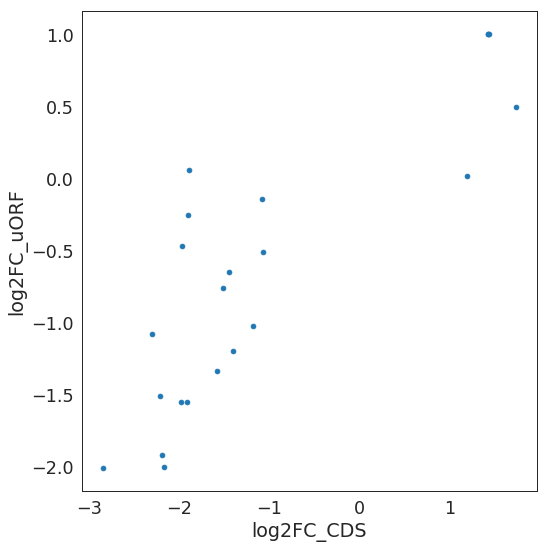

In [114]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(uorf_cds_fc_df.log2FC_CDS, uorf_cds_fc_df.log2FC_uorf)
ax.set_xlabel('log2FC_CDS')
ax.set_ylabel('log2FC_uORF')
fig.tight_layout()

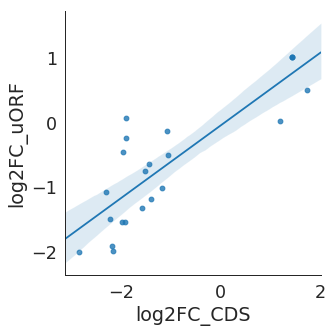

In [121]:
ax = sns.lmplot(x='log2FC_CDS', y= 'log2FC_uorf', data=uorf_cds_fc_df)
ax.set(xlabel='log2FC_CDS', ylabel = 'log2FC_uORF')
plt.savefig('uORF_CDS_log2FC.pdf')

# uORF-vs-TE Final results

In [133]:
annotation = pd.read_table('/staging/as/skchoudh/ribocop_hg38_feb2019_annotation_longest_candidate_orfs.tsv').set_index('ORF_ID')
t2g = annotation[['transcript_id', 'gene_id']].drop_duplicates().set_index('transcript_id')


In [126]:
diff_uorf_sig = pd.read_table('/home/cmb-panasas2/wenzhenl/github/ribocop-results/real/foldchange.txt')

In [131]:
diff_uorf_sig['transcript_id'] = diff_uorf_sig.ORF_ID.apply(get_tx_from_orfid)

In [135]:
diff_uorf_sig['gene_id'] = t2g.loc[diff_uorf_sig['transcript_id'], 'gene_id'].values

In [137]:
diff_uorf_sig['transcript_id'] = diff_uorf_sig['transcript_id'].apply(clean_tx)
diff_uorf_sig['gene_id'] = diff_uorf_sig['gene_id'].apply(clean_tx)

In [139]:
diff_uorf_sig.to_csv('/home/cmb-panasas2/skchoudh/github_projects/ribocop-results/real/foldchange_annotated.tsv', index=False, sep='\t')

In [145]:
diff_T_sig = pd.read_table('/home/cmb-panasas2/skchoudh/github_projects/ribocop-results/real/diff_T_sig.txt', sep=' ').reset_index().rename(columns={'index': 'ORF_ID'})
diff_T_sig['transcript_id'] = diff_T_sig.ORF_ID.apply(get_tx_from_orfid)
diff_T_sig['gene_id'] = t2g.loc[diff_T_sig['transcript_id'], 'gene_id'].values
diff_T_sig['transcript_id'] = diff_T_sig['transcript_id'].apply(clean_tx)
diff_T_sig['gene_id'] = diff_T_sig['gene_id'].apply(clean_tx)
diff_T_sig.to_csv('/home/cmb-panasas2/skchoudh/github_projects/ribocop-results/real/diff_T_sig_annotated.tsv', index=False, sep='\t')

In [144]:
diff_T_sig = pd.read_table('/home/cmb-panasas2/skchoudh/github_projects/ribocop-results/real/diff_T_sig.txt', sep=' ').reset_index().rename(columns={'index': 'ORF_ID'})
diff_T_sig['transcript_id'] = diff_T_sig.ORF_ID.apply(get_tx_from_orfid)
diff_T_sig['gene_id'] = t2g.loc[diff_T_sig['transcript_id'], 'gene_id'].values
diff_T_sig['transcript_id'] = diff_T_sig['transcript_id'].apply(clean_tx)
diff_T_sig['gene_id'] = diff_T_sig['gene_id'].apply(clean_tx)
diff_T_sig.to_csv('/home/cmb-panasas2/skchoudh/github_projects/ribocop-results/real/diff_T_sig_annotated.tsv', index=False, sep='\t')

In [146]:
diff_U_sig = pd.read_table('/home/cmb-panasas2/skchoudh/github_projects/ribocop-results/real/diff_U_sig.txt', sep=' ').reset_index().rename(columns={'index': 'ORF_ID'})
diff_U_sig['transcript_id'] = diff_U_sig.ORF_ID.apply(get_tx_from_orfid)
diff_U_sig['gene_id'] = t2g.loc[diff_U_sig['transcript_id'], 'gene_id'].values
diff_U_sig['transcript_id'] = diff_U_sig['transcript_id'].apply(clean_tx)
diff_U_sig['gene_id'] = diff_U_sig['gene_id'].apply(clean_tx)
diff_U_sig.to_csv('/home/cmb-panasas2/skchoudh/github_projects/ribocop-results/real/diff_U_sig_annotated.tsv', index=False, sep='\t')

In [150]:
with open('/home/cmb-panasas2/skchoudh/github_projects/ribocop-results/real/diff_U_sig_genelist.txt', 'w') as fh:
    for gene in diff_U_sig.gene_id.unique():
        fh.write('{}\n'.format(gene))

In [151]:
with open('/home/cmb-panasas2/skchoudh/github_projects/ribocop-results/real/diff_T_sig_genelist.txt', 'w') as fh:
    for gene in diff_T_sig.gene_id.unique():
        fh.write('{}\n'.format(gene))

In [153]:
with open('/home/cmb-panasas2/skchoudh/github_projects/ribocop-results/real/foldchange_genelist.txt', 'w') as fh:
    for gene in diff_uorf_sig.gene_id.unique():
        fh.write('{}\n'.format(gene))